## Dataset Description 

https://github.com/walkerkq/musiclyrics

Billboard has published a Year-End Hot 100 every December since 1958. The chart measures the performance of singles in the U.S. throughout the year. Using R, I’ve combined the lyrics from 50 years of Billboard Year-End Hot 100 (1965-2015) into one dataset for analysis. You can download that dataset here.

The songs used for analysis were scraped from Wikipedia’s entry for each Billboard Year-End Hot 100 Songs (e.g., 2014). This is the year-end chart, not weekly rankings. Many artists have made the weekly chart but not the final year end chart. The final chart is calculated using an inverse point system based on the weekly Billboard charts (100 points for a week at number one, 1 point for a week at number 100, etc).

I used the xml and RCurl packages to scrape song and artist names from each Wikipedia entry. I then used that list to scrape lyrics from sites that had predictable URL strings (for example, metrolyrics.com uses metrolyrics.com/SONG-NAME-lyrics-ARTIST-NAME.html). If the first site scrape failed, I moved onto the second, and so on. About 78.9% of the lyrics were scraped from metrolyics.com, 15.7% from songlyrics.com, 1.8% from lyricsmode.com. About 3.6% (187/5100) were unavailable.

The dataset features 5100 observations with the features rank (1-100), song, artist, year, lyrics, and source. The artist feature is fairly standardized thanks to Wikipedia, but there is still quite a bit of noise when it comes to artist collaborations (Justin Timberlake featuring Timbaland, for example). If there were any errors in the lyrics that were scraped, such as spelling errors or derivatives like "nite" instead of "night," they haven't been corrected.

Full analysis can be found here.

# Imports and Data Loading

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

from Levenshtein import distance as levenshtein_distance

import matplotlib.pyplot as plt

### Lyrics Top-100 dataset

In [2]:
data_file_incomplete = "datasets/billboard_lyrics_1964-2015.csv"
data_file = "datasets/billboard_full.csv"

df_incomplete = pd.read_csv(data_file_incomplete, encoding = "ANSI") # utf-8 encoding doesn't work somehow :(
df = pd.read_csv(data_file, index_col=0, header=0, sep=";") 

df.head()

,Rank,Song,Artist,Year,Lyrics,Genre,Album
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,rock,wooly bully
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...,r&b soul,greatest hits in concert
2,3,i cant get no satisfaction,the rolling stones,1965,i cant get no satisfaction i cant get no satis...,rock,out of our heads
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,folk,love me not tomorrow
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,r&b soul,top gun


In [3]:
len(df.Artist.unique())

2471

## Number of years in Top 100 per Song

In [4]:
df_count = df.groupby(["Artist", "Song"]).Year.agg(list).to_frame()
df_count["Count"] = df_count.Year.apply(len)
df_count = df_count.sort_values("Count", ascending = False)
df_count.head()

,,Year,Count
Artist,Song,,
psy,gangnam style,"[2012, 2013]",2
chingy featuring ludacris and snoop dogg,holidae in,"[2003, 2004]",2
snap,rhythm is a dancer,"[1992, 1993]",2
the band perry,if i die young,"[2010, 2011]",2
katy perry,hot n cold,"[2008, 2009]",2


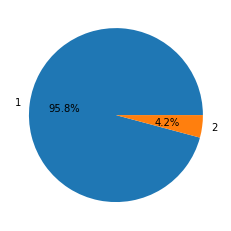

In [5]:
plt.pie(df_count["Count"].value_counts(), labels = [1, 2], autopct='%1.1f%%')
plt.show()

## Genre

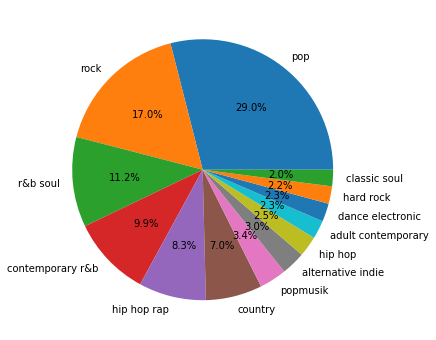

In [6]:
vc_genre = df.Genre.value_counts()
vc_genre = vc_genre[vc_genre > 70] # Filter very unfrequent

plt.figure(figsize=(10,6))
plt.pie(vc_genre.values, labels = vc_genre.index, autopct='%1.1f%%')
plt.savefig("images/genre_distribution.png")
plt.show()

## Number of songs in top 100 per artist (if a song is twice, is counted twice)

In [7]:
df.Artist.value_counts().describe()

count    2471.000000
mean        2.071226
std         2.499187
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        35.000000
Name: Artist, dtype: float64

In [8]:
df_songCounts = df.groupby("Artist").Song.count()
df_rndArtist = df_songCounts.to_frame().reset_index().groupby("Song").agg(list)
df_rndArtist["Artist"] = df_rndArtist["Artist"].apply(lambda a : np.random.choice(a, 1)[0])

df_labels = pd.DataFrame(range(1, df_songCounts.max() + 1), columns = ["Song"])
df_labels["Artist"] = ""
df_labels = df_labels.set_index("Song")
df_labels.update(df_rndArtist)

In [9]:
tmp = df_songCounts.value_counts()
tmp[tmp.index <= 3].sum() / tmp.sum()

0.8696883852691218

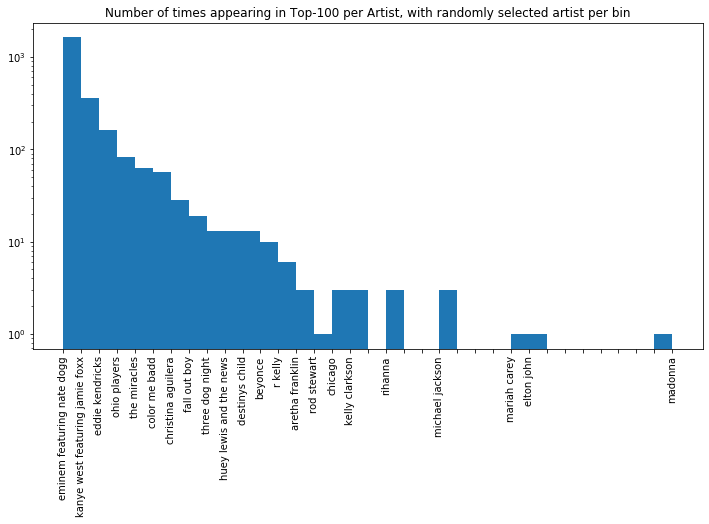

In [10]:
bins = range(1, df_songCounts.max() + 1)
plt.figure(figsize=(12,6))
plt.hist(df_songCounts, bins = bins)
plt.xticks(bins, df_labels["Artist"], rotation='vertical')
plt.yscale("log")
plt.title("Number of times appearing in Top-100 per Artist, with randomly selected artist per bin")
plt.savefig("images/songs_per_artist.png", bbox_inches='tight')
plt.show()

## Lyrics statistics

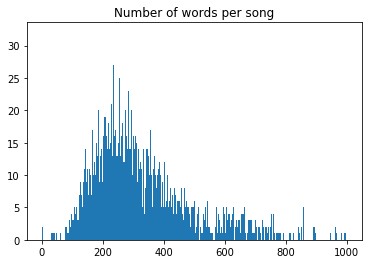

In [11]:
lyrics_lengths = df.Lyrics.apply(lambda s : len(s.split(" ")))

bins = range(1, 1000)
plt.hist(lyrics_lengths, bins = bins)
plt.title("Number of words per song")
plt.savefig("words.png")
plt.show()

In [12]:
lyrics_lengths.describe()

count    5118.000000
mean      331.316335
std       172.539269
min         1.000000
25%       215.250000
50%       293.000000
75%       406.000000
max      1505.000000
Name: Lyrics, dtype: float64

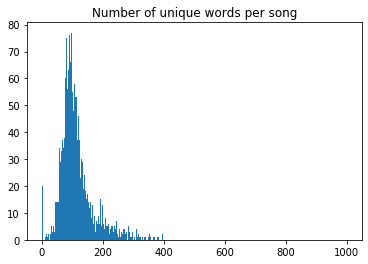

In [13]:
lyrics_lengths_unique = df.Lyrics.apply(lambda s : len(set(s.split(" "))))

bins = range(1, 1000)
plt.hist(lyrics_lengths_unique, bins = bins)
plt.title("Number of unique words per song")
plt.savefig("unique_words.png")
plt.show()

In [14]:
lyrics_lengths_unique.describe()

count    5118.000000
mean      113.092614
std        55.243937
min         1.000000
25%        80.000000
50%       100.000000
75%       129.000000
max       433.000000
Name: Lyrics, dtype: float64

### Clusterisation of texts

In [15]:
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

def lemmatize(token, pos_tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(pos_tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

def preprocess_lyrics(lyrics):
    tagged_tokens = pos_tag(wordpunct_tokenize(lyrics))
    preprocessed = [lemmatize(token, tag) for (token, tag) in tagged_tokens if not token in stop_words]
    return " ".join(preprocessed)

In [16]:
preprocessed_lyrics = df.Lyrics.fillna("").apply(preprocess_lyrics)

In [17]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english', preprocessor = None)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(preprocessed_lyrics)

In [18]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 4
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
love yeah like im

Topic #1:
la like dont say

Topic #2:
like im dance da

Topic #3:
oh im know girl

Topic #4:
love dont know baby


In [19]:
vectors_10 = lda.transform(count_data)

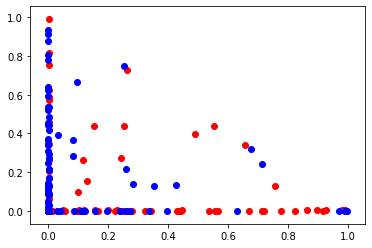

In [20]:
plt.scatter(vectors_10[:100, 0], vectors_10[:100, 1], color = "red")
plt.scatter(vectors_10[5000:, 0], vectors_10[5000:, 1], color = "blue")

plt.show()

In [21]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(vectors_10)

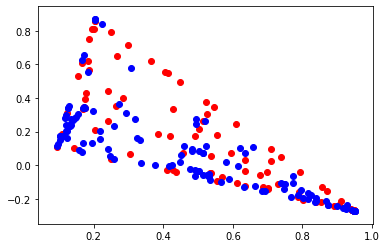

In [22]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

## Using Doc2Vec

In [23]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(df.Lyrics.fillna(""))]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs = 10, dbow_words = 1)

In [24]:
sentence = "I cant get no satisfaction"
vector = model.infer_vector(sentence.split(" "))
documents[model.docvecs.most_similar([vector])[1][0]]

TaggedDocument(words=['instrumental'], tags=[301])

In [25]:
documents[4480]

TaggedDocument(words=['', 'ive', 'practiced', 'this', 'for', 'hours', 'gone', 'round', 'and', 'round', 'and', 'now', 'i', 'think', 'that', 'ive', 'got', 'it', 'all', 'down', 'and', 'as', 'i', 'say', 'it', 'louder', 'i', 'love', 'how', 'it', 'sounds', 'cause', 'im', 'not', 'taking', 'the', 'easy', 'way', 'out', 'not', 'wrappin', 'this', 'in', 'ribbons', 'shouldnt', 'have', 'to', 'give', 'a', 'reason', 'whyits', 'no', 'surprise', 'i', 'wont', 'be', 'here', 'tomorrow', 'i', 'cant', 'believe', 'that', 'i', 'stayed', 'till', 'today', 'yeah', 'you', 'and', 'i', 'will', 'be', 'a', 'tough', 'act', 'to', 'follow', 'but', 'i', 'know', 'in', 'time', 'well', 'find', 'this', 'was', 'no', 'surpriseit', 'came', 'out', 'like', 'a', 'river', 'once', 'i', 'let', 'it', 'out', 'when', 'i', 'thought', 'that', 'i', 'wouldnt', 'know', 'how', 'held', 'onto', 'it', 'forever', 'just', 'pushing', 'it', 'down', 'felt', 'so', 'good', 'to', 'let', 'go', 'of', 'it', 'now', 'not', 'wrapping', 'this', 'in', 'ribbons',

In [26]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(model.docvecs.vectors_docs)

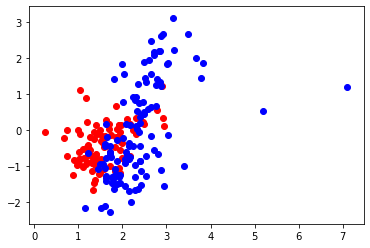

In [27]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

In [30]:
len(model.docvecs.vectors_docs)

5118

In [47]:
pd.DataFrame(model.docvecs.vectors_docs).to_csv("vec.tsv", index = False, sep = "\t", header=False)

In [48]:
df.to_csv("data.tsv", sep = "\t", index = False)